In [1]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

## 0. 初めに

このnotebookはNNPを用いた触媒計算について、その威力を実体験いただくことを目的とします。

不均一触媒に使えるNNP、すなわちDFTの一部を超高速かつ高精度に代替する分子力場として、Open Catalyst Projectが挙げられます。この力場はFacebook社を中心としたコンピュータリソースをもとに作成されたDFT計算（構造と力、エネルギー）のビッグデータを学習するコンペティションにより得られるもので、誰でも使用する事ができます。ただ、コンペティションの常として、力場の精度向上に関する取組は多く行われている一方で、実際にこれを使ってなにがしかの課題を設定し解くという向きについてはまだ公知の情報に乏しいという悩みがございます。

本セミナーおよびnotebookは、この悩みを解決することを主なターゲットとし、以下の情報を具体例とともに体験学習することができます。

・OCP力場および計算環境の構築方法

・OCP力場を用いた計算フローの「ひな型」

ここで「ひな型」と書いたのは、計算化学的なアプローチにより触媒構造を明らかにする際にはしかるべき手順があるということを（計算化学についてはずぶの素人である作成者自身が試行錯誤と有識者へのヒアリングにより経験した話として）強調するためです。しかるべき手順といっても、その一つ一つは非常に明快な論理に基づく要請であり、かつ個々の応用先が変わったとしてもこれらひな型にはほぼ変わりがありません。従って、当セミナーにてこれら一連の流れを実体験していただくことは一定の意義があるだろうと考えています。何しろ、NNPの普及はありとあらゆる実験家に対し、オンタイムで実験結果を解釈しかつ要すれば逆解析までを可能とする計算化学の枠組を提示しているのです。とりもなおさず今、この文章を目にしているあなたの手中にも。

黎明期の常として、当スクリプト群は発展途上のものであり、計算方法には改善の余地がございます。これらについて継続して改良することは言うまでもありませんが、それでも現時点においてNNPが触媒開発に対し、現実的に役立つ計算化学的手法として躍り出たことを私は確信しています。また、その出現に立ち会えたことは研究者として純粋なよろこびでした。

それでは、NNP を たいけん する ぼうけん の たび へ レッツ ゴー！

2023.1.14 Masaki Open Lab

## 1. 学習済みモデル（力場）のダウンロード

学習済みのモデルを右記リンクからダウンロードします。[here](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md)学習済みのモデルはASEのCalculatorクラスとして使用できます。

※今回はリンク先から該当ファイルを直接ダウンロードしocpフォルダに格納しました。なお当セミナーでは純金属を取り扱うためoc20モデルを使用しましたが、酸化物触媒を使用される場合はoc22モデルを検討ください。

In [45]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import LBFGS
from ase.build import fcc100, fcc111, add_adsorbate, molecule
import os
from ase.constraints import FixAtoms
import numpy as np
from ase.io import extxyz

import ase
from ase import Atoms, units, Atom
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort
import pandas as pd
from ase.build import bulk

#モデルの置き場所（絶対パスで指定）
checkpoint_path = "C:/Users/****/ocp/gemnet_t_direct_h512_all.pt"
config_yml_path = r"C:/Users/****/ocp/configs/s2ef/all/gemnet/gemnet-dT.yml"

#Define the calculator
calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path, cpu = False)

OSError: [Errno 22] Invalid argument: 'C:/Users/****/ocp/configs/s2ef/all/gemnet/gemnet-dT.yml'

## 2. Cu上におけるCOの吸着エネルギー計算
典型的な例として、Cu FCC(111)面のトップサイトにおけるCOの吸着エネルギーを各種金属に対して計算し、文献値と比較してみます。COは各種基礎的な化学反応の原料であり、その吸着エネルギーが計算できることは触媒設計上極めて有用な情報を提供することに他なりません。

吸着エネルギーの計算は以下のような手順をとります。以下順に実施していきます。

①対象となる結晶構造の入手とbulk構造の最適化

②結晶構造から表面を切り出し、slab構造を最適化

③吸着対象分子について、slab構造にのせた状態で構造を最適化

④slab構造と吸着構造との差から、吸着エネルギーを計算

## 2-1. 結晶構造の入手とbulk構造の最適化

まずはバルク結晶構造を入手し、格子定数を最適化します。今回使用しているASEパッケージには一般的な金属の構造がすぐに引き出せる関数で用意されています。ここでは、単一金属結晶構造をbulk関数で呼び出し、その後OCP力場の下でこの格子定数を最適化してみましょう。ごく単純な実装として、格子定数をデフォルトの値から±1%（ここは任意）変化させ、最も安定な構造を選ぶこととします。

In [4]:
#格子定数を任意の範囲で振ってエネルギー最適点を求める関数
def opt_bulk(metal, min_a, max_a):
    a = [] #格子定数の倍数
    a = pd.DataFrame(np.empty((0, 2)), columns = ["energy", "a"])
    for i in np.linspace(min_a, max_a):
        bulk_test = bulk(metal)
        ref = bulk_test.cell
        bulk_test.cell = i * ref
        bulk_test.set_tags(np.ones(len(bulk_test)))

        bulk_test.calc = calc

        e = (bulk_test.get_potential_energy())
        a = a.append({"energy": e,
                      "a": i}, ignore_index = True)

        del bulk_test, ref
    
    return a["a"][a['energy'].idxmin()]

In [6]:
import warnings
warnings.simplefilter('ignore')

Opt_Cu_bulk_a = opt_bulk("Cu", 0.99, 1.01)
print(Opt_Cu_bulk_a)

1.0046938775510204


## コラム①：格子定数の最適化手法とその意義

受講者の皆様はお気づきの通り、今回実装した格子定数の最適化手法は最もナイーブな方法の一つであり、hydtrostatic_strainという束縛がかかっています。つまり、格子のa,b,c軸がもとと同じ比率を保って最適化されるため、一部の軸については最適化しきれない可能性が残ります。

ASEには様々な束縛条件を付けた最適化関数が用意されていますが、2023.1現在、当方が調べた限りにおいてOCP力場ではデフォルトの最適化関数を使用するとエラーを生じてしまいます（またこれに関連し、bulk構造の計算については以下のissueがopenとなっています）。従いまして、今回はナイーブを承知で上記のような関数を自前で実装した次第です。

<https://github.com/Open-Catalyst-Project/ocp/issues/428>

尚、格子定数の最適化手法やその意義について詳しくは以下を参照いただくことが好ましいと考えます。ここでは実験家にとって重要と思われる事項を抜粋します。このような情報が無料で手に入るというのも、2020年代の大きな特色です。

"現実世界の物質の原子配置がどのように決まっているかについて考えてみますと、一つ一つの原子は特に拘束もなく自由に動き回っているので、余計なエネルギーは散逸し、エネルギーの低い安定な構造へと変化していきます。一旦温度の影響を無視して十分に温度が低い場合を考えてみると、その場合は原子の運動エネルギーは0になり、ポテンシャルエネルギーは極小値をとることが考えられます。その意味では構造最適化計算は現実世界における絶対零度の状態を考えていることに対応しています。

有限温度の場合にはどうでしょうか。統計力学の理論から、平衡状態にある系では温度と運動エネルギーは一定の関係にあることが知られており、大雑把な計算では1 Kの上昇はおおまかに1/10000 eV/atomの運動エネルギーの上昇に相当します。逆にいうと、1 eV/atomのエネルギーの上昇は温度に換算して10000 K程度の構造に相当するということです。このように有限温度の場合でもしばしばエネルギーを最適化した構造が十分に良い近似となることが多いため、シミュレーションのはじめにまずは構造最適化計算をしよう(有限温度の場合にはその後で温度を上昇させよう)という手順をとることが一般に行われています。

構造最適化計算を行わずにシミュレーションをしてしまうと、前提条件の違いにより非現実的な結果をもたらしてしまう可能性があります。例えば鉄の結晶構造を1%小さくとった場合、原子構造を可視化しただけであれば特段の変化は見えないかもしれません。しかし現実世界で鉄を1%縮める操作を考えてみればわかるように、これは非常に強い圧縮力(具体的には1 GPaを超える圧力)のかかった鉄に相当するので、シミュレーションの結果を変えてしまうことが想定されます。"

<https://docs.matlantis.com/atomistic-simulation-tutorial/ja/2_2_opt_symmetry.html>

## コラム②：最適化アルゴリズム

最適化アルゴリズムについて、日本国内で入手できる最高の情報源は下記となります。

<https://docs.matlantis.com/atomistic-simulation-tutorial/ja/2_3_opt-algorithm.html>



## 2-2. 表面の切り出しとslab構造の最適化、表面エネルギーの算出

バルクの格子定数が最適化できたら、その格子定数を用いて表面構造を作成、最適化し表面エネルギーを算出します。このとき考えるべきポイントは大きく3つあり、一つは表面の切り出し方、もう一つは最適化手法（前述）、そして最後は束縛条件です。

一つ目に関しASEには典型的な表面を切り出す関数が複数用意されており、ここではその中からfcc111関数を使用します。もちろんこれだけではなく、よりカスタマイズされた表面の切り出し方もあります（当セミナーの後に発展編として事例紹介の予定）。また二つ目について、今回はLBFGS法を使用しました。

三つ目の束縛条件について、具体的にはFixAtoms関数がこれに相当します。今回は原子にタグをつけ、最表面の原子以外は最適化計算において動かないものとする、という仮定を置きました（タグの付け方をここでは完全に手動で設定していますが、任意の結晶構造について最表面の原子がどれであるかを機械的に定義し固定することも勿論可能です…詳細は下記）。

<https://docs.matlantis.com/atomistic-simulation-tutorial/ja/5_2_neb_catalyst.html>

In [37]:
def Calculate_slab_energy_fcc111(metal, fmax, steps):
    #格子定数を最適化
    bulk_test = bulk(metal)
    ref = bulk_test.cell
    Opt_bulk_a = opt_bulk(metal, 0.99, 1.01) * ref[0,2]*2
    print(Opt_bulk_a)
    
    #金属のみの構造最適化とエネルギー計算
    adslab = fcc111(metal, a=Opt_bulk_a, size=(3, 3, 3))

    # tag all slab atoms below surface as 0, surface as 1, adsorbate as 2
    tags = np.zeros(len(adslab))
    tags[18:27] = 1
    tags[27:] = 2
    adslab.set_tags(tags)

    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
    adslab.set_constraint(cons)
    adslab.center(vacuum=13.0, axis=2)
    adslab.set_pbc(False)

    # Set up the calculator
    adslab.set_calculator(calc)
    os.makedirs('data', exist_ok=True)
    # Define structure optimizer - LBFGS. Run for 100 steps, 
    # or if the max force on all atoms (fmax) is below 0 ev/A.
    # fmax is typically set to 0.01-0.05 eV/A, 
    # for this demo however we run for the full 100 steps.
    dyn = LBFGS(adslab, trajectory="data/" + metal + "_relax.traj")
    dyn.run(fmax=fmax, steps=steps)
    traj_metal = ase.io.read("data/" + metal + "_relax.traj", ":")
    # convert traj format to extxyz format (used by OC20 dataset)
    columns = (['symbols','positions', 'move_mask', 'tags'])
    with open("data/" + metal + "_relax.extxyz",'w') as f:
        extxyz.write_xyz(f, traj_metal, columns=columns)

    #最適化後の金属構造をロードし、エネルギーを出力
    final_structure = traj_metal[-1]
    raw_slab_energy = final_structure.get_potential_energy()
    
    return raw_slab_energy

In [38]:
raw_slab_energy = Calculate_slab_energy_fcc111("Cu", 0.05, 100)

3.6269448979591834
       Step     Time          Energy         fmax
LBFGS:    0 15:24:21       -0.732217        0.8514
LBFGS:    1 15:24:21       -0.709654        0.8003
LBFGS:    2 15:24:21       -0.767039        0.5478
LBFGS:    3 15:24:21       -0.827158        0.3242
LBFGS:    4 15:24:21       -0.835795        0.2935
LBFGS:    5 15:24:21       -0.905722        0.0724
LBFGS:    6 15:24:21       -0.911677        0.0848
LBFGS:    7 15:24:21       -0.910762        0.1040
LBFGS:    8 15:24:21       -0.908585        0.1013
LBFGS:    9 15:24:21       -0.904931        0.0773
LBFGS:   10 15:24:21       -0.904404        0.0656
LBFGS:   11 15:24:21       -0.906519        0.0701
LBFGS:   12 15:24:21       -0.908375        0.0554
LBFGS:   13 15:24:21       -0.909457        0.0362


## 2-3. 吸着構造の最適化

引き続いて、先ほど作成したのと同様のslab構造に対しし所望の分子を吸着させた構造を作成、これを最適化します。今回は簡単のために対象外としましたが、より詳細な計算を行う場合には以下の2点に注意する必要があります。

1つ目は吸着サイトの選び方です。単一金属からなるスラブモデルでも、金属原子のontopに吸着するのか、bridgeなのか、hcpなのか…といった吸着点の選び方により吸着構造のエネルギーは変化します。これが複数の元素からなる合金であればなおさらです。従ってより厳密には、様々なサイトに対し吸着構造の最適化を行い、その分布を化学的な視点で解析することで系の理解に努めることが求められます（どんなツールを使うかによらず、計算結果を出発点としてどのように考えるかが大事です…MatlantisのYouTubeではこの考える、という部分をArtと称しておりました）。なおASEではadd_adsorbate関数上のoffsetを変更することでサイトを任意に設定できるほか、典型的な表面についてはontop, bridgeといったワードでサイトを指定することも可能です。

2つ目は吸着分子の「向き」です。例えば、対象とする分子におけるC-H結合のHが金属と相互作用するという仮定に基づき吸着構造の最適化を行うとします。にもかかわらず、対象とする分子の初期配置において、所望の結合が金属表面と正反対におかれていたらどうなるでしょう？　もしかしたら最適化計算により結合の向きがうまく金属側に来てくれるかもしれませんが、さもなければ意図した吸着構造と全く異なるものを求めてしまうことが想像されます。こうしたノイズを避けるために、moleculeを予め回転や平行移動することで所望の吸着構造をなるべく取りやすくする、という工夫が必要となります。ASEではrotate関数をはじめとする様々な機能が付与されており、こうした調整を簡単に行う事が出来ます（これらについても、セミナーの事例紹介を参照ください）。

<https://docs.matlantis.com/atomistic-simulation-tutorial/ja/1_6_ase_playground.html#%E5%B9%B3%E8%A1%8C%E7%A7%BB%E5%8B%95%E3%80%81%E5%9B%9E%E8%BB%A2>

In [33]:
def Calculate_adsorption_energy_fcc111(metal, mol, fmax, steps):
    #格子定数を最適化
    bulk_test = bulk(metal)
    ref = bulk_test.cell
    Opt_bulk_a = opt_bulk(metal, 0.99, 1.01) * ref[0,2]*2
    print(Opt_bulk_a)
    
    #COと金属の吸着構造最適化とエネルギーの計算
    adslab = fcc111(metal, a=Opt_bulk_a, size=(3, 3, 3))
    adsorbate = molecule(mol)
    add_adsorbate(adslab, adsorbate, 3, offset=(1, 1)) # adslab = adsorbate + slab

    # tag all slab atoms below surface as 0, surface as 1, adsorbate as 2
    tags = np.zeros(len(adslab))
    tags[18:27] = 1
    tags[27:] = 2
    adslab.set_tags(tags)
    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
    adslab.set_constraint(cons)
    adslab.center(vacuum=13.0, axis=2)
    adslab.set_pbc(False)
    # Set up the calculator
    adslab.set_calculator(calc)
    os.makedirs('data', exist_ok=True)
    # Define structure optimizer - LBFGS. Run for 100 steps, 
    # or if the max force on all atoms (fmax) is below 0 ev/A.
    # fmax is typically set to 0.01-0.05 eV/A, 
    # for this demo however we run for the full 100 steps.
    dyn = LBFGS(adslab, trajectory="data/" + metal + "_co_relax.traj")
    dyn.run(fmax=0.05, steps=100)
    traj = ase.io.read("data/" + metal + "_co_relax.traj", ":")
    # convert traj format to extxyz format (used by OC20 dataset)
    columns = (['symbols','positions', 'move_mask', 'tags'])
    with open("data/" + metal + "_co_relax.extxyz",'w') as f:
        extxyz.write_xyz(f, traj, columns=columns)

    #最適化後の吸着構造をロードし、エネルギーを出力
    final_structure = traj[-1]
    relaxed_energy = final_structure.get_potential_energy()
    
    return relaxed_energy

作成した関数を用いて、Cu上のCO吸着構造を最適化してみます。

In [34]:
relaxed_energy = Calculate_adsorption_energy_fcc111("Cu", "CO", 0.05, 100)

3.6269448979591834
       Step     Time          Energy         fmax
LBFGS:    0 15:21:51        0.119126        1.5146
LBFGS:    1 15:21:51        0.039461        2.2268
LBFGS:    2 15:21:51       -0.065428        1.2539
LBFGS:    3 15:21:51       -0.330648        1.3239
LBFGS:    4 15:21:51       -0.390798        0.5037
LBFGS:    5 15:21:51       -0.461710        0.4463
LBFGS:    6 15:21:51       -0.506664        0.9608
LBFGS:    7 15:21:51       -0.543631        1.0114
LBFGS:    8 15:21:52       -0.547412        0.5836
LBFGS:    9 15:21:52       -0.525919        0.3501
LBFGS:   10 15:21:52       -0.526044        0.6787
LBFGS:   11 15:21:52       -0.550006        0.8175
LBFGS:   12 15:21:52       -0.597113        0.5774
LBFGS:   13 15:21:52       -0.651618        0.2536
LBFGS:   14 15:21:52       -0.685208        0.2262
LBFGS:   15 15:21:52       -0.692503        0.2594
LBFGS:   16 15:21:52       -0.689666        0.2147
LBFGS:   17 15:21:52       -0.680430        0.0995
LBFGS:   18 1

吸着構造の最適化が完了したら、吸着エネルギーに換算します。吸着エネルギーは、吸着構造のエネルギー - （表面のエネルギー + 吸着分子単独のエネルギー）で求められます。ここで、吸着分子単独のエネルギーについては簡単のため、各原子の参照エネルギーを仮定しその総和で表すことにします。

注意：このような単純化がいかなる時に許容されるかという点はよく考えておく必要があります。例えば、算出された吸着エネルギー（もしくはそれらの特徴量エンジニアリングにより得られる値）を相対的な特徴量として、なにがしか別の物性について議論するという場合を考えてみましょう。このようなケースにおいて、先に仮定した分子の参照エネルギーは単なる「ゲタ」であり、相対比較においては無視することができます。一方で、吸着エネルギーの絶対値に依拠して別の物性（例えば平衡）を算出する場合には、より厳密な計算が求められます。

In [35]:
def calculate_adsorption_energy(mol, raw_slab_energy, relaxed_energy):
    adsorbate = Atoms(mol).get_chemical_symbols()
    # For clarity, we define arbitrary gas reference energies here.
    # A more detailed discussion of these calculations can be found in the corresponding paper's SI. 
    gas_reference_energies = {'H': .3, 'O': .45, 'C': .35, 'N': .50}
    adsorbate_reference_energy = 0
    for ads in adsorbate:
        adsorbate_reference_energy += gas_reference_energies[ads]
#    print(f'Adsorbate reference energy = {adsorbate_reference_energy} eV\n')
    adsorption_energy = relaxed_energy - raw_slab_energy - adsorbate_reference_energy
#    print(f'Adsorption energy: {adsorption_energy} eV')
    
    return adsorption_energy


計算値を出力します。参考までに、実験値は-0.5 eVでした。

In [36]:
calculate_adsorption_energy("CO", raw_slab_energy, relaxed_energy)

-0.6049557209014893

## （参考）CO吸着エネルギーの文献値比較

https://link.aps.org/accepted/10.1103/PhysRevB.100.035442  
こちらをもとに、種々の汎関数によるDFT計算結果とOCP力場による計算結果を比較してみます。  
※GPU環境がないとこの計算は少し重いので、こちらについては余裕のある方だけお試しください。

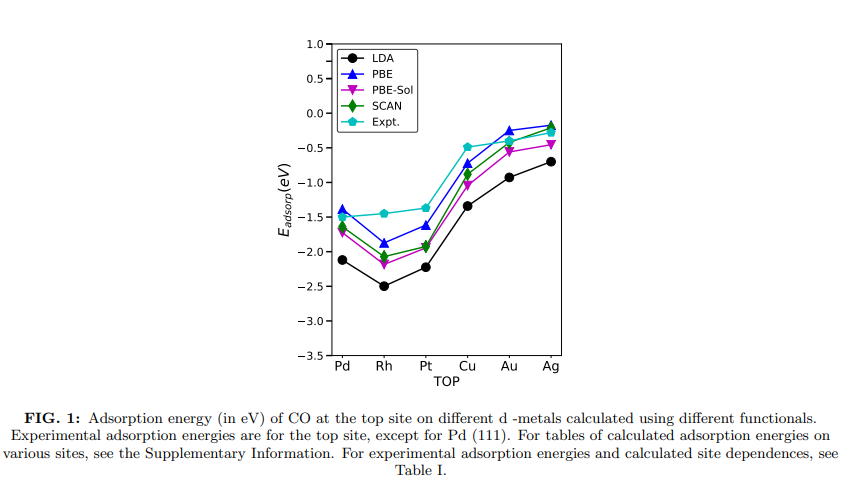

In [39]:
metals = ["Pd", "Rh", "Pt", "Cu", "Au", "Ag"]
ads_energy = []
for metal in metals:

    raw_slab_energy = Calculate_slab_energy_fcc111(metal, 0.05, 100)
    relaxed_energy = Calculate_adsorption_energy_fcc111(metal, "CO", 0.05, 100)
    
    adsorption_energy = calculate_adsorption_energy("CO", raw_slab_energy, relaxed_energy)
    print(f'Adsorption energy: {adsorption_energy} eV')
    ads_energy.append(adsorption_energy)

3.878091836734694
       Step     Time          Energy         fmax
LBFGS:    0 15:25:34       -1.054435        1.0455
LBFGS:    1 15:25:34       -1.046233        0.9656
LBFGS:    2 15:25:34       -0.822875        0.7974
LBFGS:    3 15:25:34       -0.936503        0.5501
LBFGS:    4 15:25:34       -0.898508        0.3742
LBFGS:    5 15:25:34       -0.754269        0.2211
LBFGS:    6 15:25:34       -0.712843        0.2261
LBFGS:    7 15:25:34       -0.725551        0.2383
LBFGS:    8 15:25:34       -0.745426        0.2110
LBFGS:    9 15:25:35       -0.786130        0.1407
LBFGS:   10 15:25:35       -0.826246        0.1401
LBFGS:   11 15:25:35       -0.891329        0.1161
LBFGS:   12 15:25:35       -0.950428        0.1009
LBFGS:   13 15:25:35       -0.963914        0.1104
LBFGS:   14 15:25:35       -0.955543        0.1037
LBFGS:   15 15:25:35       -0.923335        0.1151
LBFGS:   16 15:25:35       -0.880606        0.1162
LBFGS:   17 15:25:35       -0.864716        0.1640
LBFGS:   18 15

LBFGS:    2 15:25:52        0.889062        3.0241
LBFGS:    3 15:25:52        0.185268        1.4322
LBFGS:    4 15:25:52        0.153833        2.2504
LBFGS:    5 15:25:52        0.230297        2.2934
LBFGS:    6 15:25:52        0.379455        0.9804
LBFGS:    7 15:25:52        0.253416        0.8153
LBFGS:    8 15:25:52        0.227452        1.4736
LBFGS:    9 15:25:52       -0.101094        1.7090
LBFGS:   10 15:25:52       -0.507356        1.0563
LBFGS:   11 15:25:52       -0.975302        0.2368
LBFGS:   12 15:25:52       -0.904387        0.2875
LBFGS:   13 15:25:52       -0.814025        0.4966
LBFGS:   14 15:25:52       -0.826795        0.5419
LBFGS:   15 15:25:52       -0.903817        0.3214
LBFGS:   16 15:25:52       -0.903465        0.2366
LBFGS:   17 15:25:52       -0.889365        0.2681
LBFGS:   18 15:25:52       -0.998706        0.3639
LBFGS:   19 15:25:52       -1.085141        0.2115
LBFGS:   20 15:25:52       -1.051948        0.1180
LBFGS:   21 15:25:53       -1.0

LBFGS:   57 15:26:07        1.115571        0.7140
LBFGS:   58 15:26:07        1.028464        0.1863
LBFGS:   59 15:26:08        1.028770        0.3530
LBFGS:   60 15:26:08        0.933106        0.4718
LBFGS:   61 15:26:08        0.879363        0.4928
LBFGS:   62 15:26:08        0.859763        0.3799
LBFGS:   63 15:26:08        0.861241        0.1777
LBFGS:   64 15:26:08        0.854204        0.2222
LBFGS:   65 15:26:08        0.827176        0.3932
LBFGS:   66 15:26:08        0.778920        0.3642
LBFGS:   67 15:26:08        0.727724        0.3036
LBFGS:   68 15:26:08        0.715209        0.2404
LBFGS:   69 15:26:08        0.698667        0.2615
LBFGS:   70 15:26:08        0.741963        0.7085
LBFGS:   71 15:26:08        0.717988        0.2254
LBFGS:   72 15:26:08        0.716821        0.3021
LBFGS:   73 15:26:08        0.682650        0.2303
LBFGS:   74 15:26:08        0.705456        0.3473
LBFGS:   75 15:26:08        0.678519        0.7524
LBFGS:   76 15:26:08        0.6

In [40]:
ads_energy

[-0.9364737749099732,
 -1.7894325733184815,
 -0.9257303953170777,
 -0.6048824071884156,
 -0.32112761139869694,
 -0.5012064456939698]

## 各種計算手法および実測値との比較
下記文献からFCC(111) ontopへのCO吸着エネルギーに関する計算値および実測値を引用しました。
https://arxiv.org/pdf/cond-mat/0408394.pdf

In [41]:
import pandas as pd
df_calc = pd.DataFrame(
    data={'LDA': [-2.12,-2.49,-2.22,-1.34,-0.93,-0.7], 
          'PBEsol': [-1.72,-2.18,-1.94,-1.05,-0.56,-0.45],
          'PBE': [-1.38,-1.87,-1.61,-0.72,-0.25,-0.17],
         "SCAN": [-1.64,-2.07,-1.92,-0.88,-0.42,-0.21],
         "Expt": [-1.48,-1.45,-1.37,-0.5,-0.4,-0.28]}
)

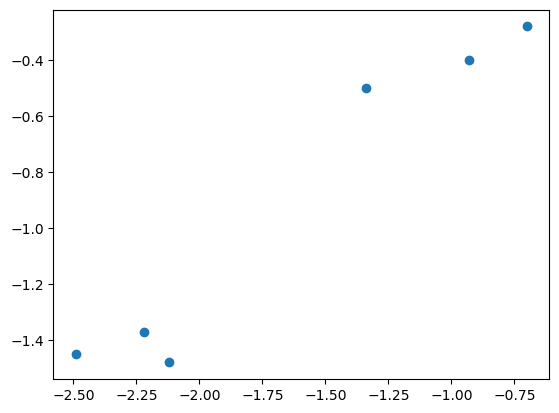

-0.2204284234114844


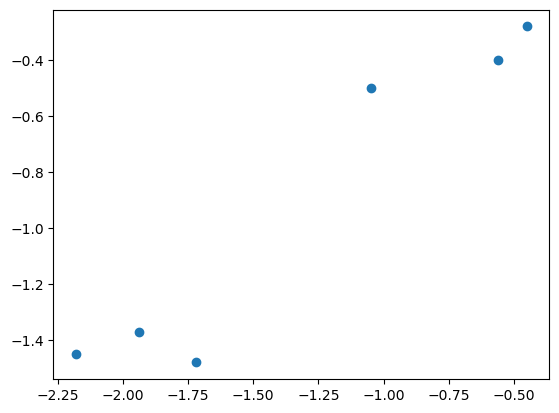

0.5272231855338123


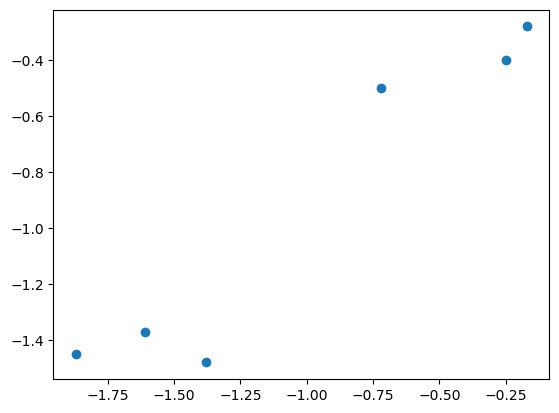

0.8743853718500307


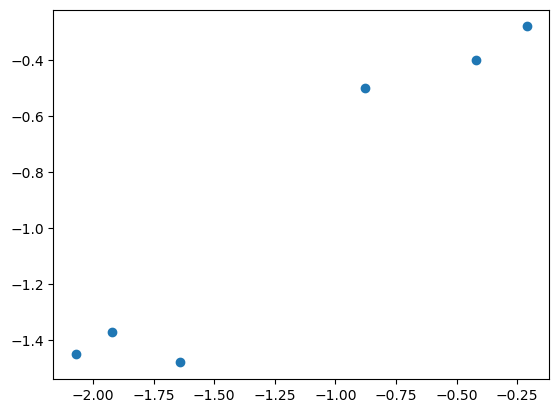

0.7270828057736136


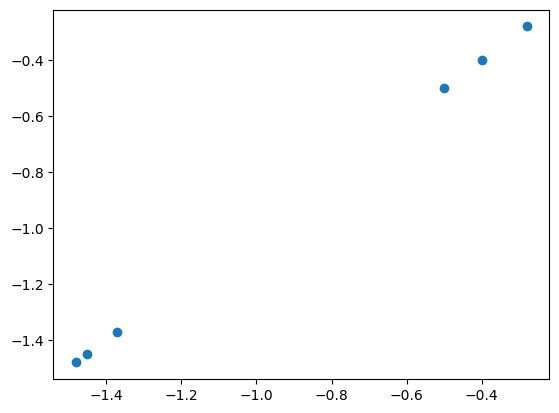

1.0


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

r2_DFT = []
for method in df_calc:
    fig, ax = plt.subplots(facecolor="w")
    ax.scatter(df_calc[method], df_calc["Expt"])
    plt.show()    
    print(r2_score(df_calc[method], df_calc["Expt"]))
    r2_DFT.append(r2_score(df_calc[method], df_calc["Expt"]))

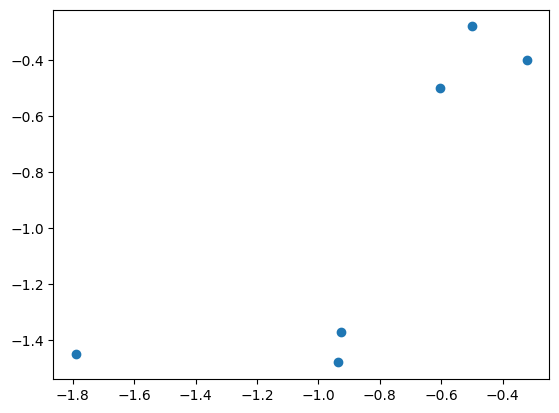

0.5032381374670885


In [43]:
fig, ax = plt.subplots(facecolor="w")
ax.scatter(ads_energy, df_calc["Expt"])
plt.show()    
print(r2_score(ads_energy, df_calc["Expt"]))
r2_DFT.append(r2_score(ads_energy, df_calc["Expt"]))

実測値とのr2を測定比較します。OC20はそのほかの計算手法に比してそん色ない精度を持つことが示されました。
（OC20のデータセットには当然この手の最も典型的な構造は網羅されているでしょうから、こういう結果が出ることは自明ではあります）

<BarContainer object of 6 artists>

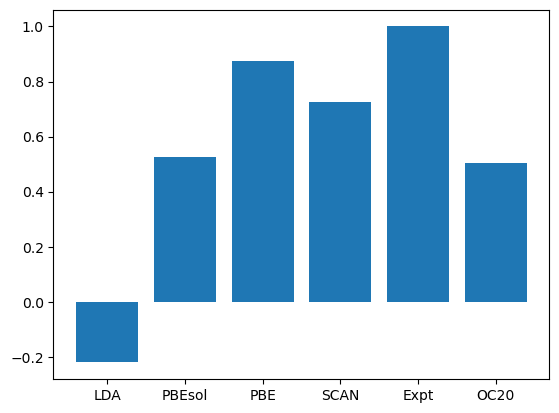

In [44]:
plt.bar(df_calc.columns.to_list() + ['OC20'],r2_DFT)